In [11]:
import numpy as np
import os
from keras.layers import Conv3D, MaxPooling3D
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential
from keras.layers import Activation, ZeroPadding3D, TimeDistributed, LSTM, GRU, Reshape
#from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gc
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.preprocessing import LabelEncoder
import sklearn
import seaborn as sns
import tensorflow as tf
from keras import regularizers
from tensorflow.keras.utils import to_categorical
from prettytable import PrettyTable
from matplotlib import pyplot as plt

import time

In [3]:
import os
import cv2

def extract_frames(video_folder, output_folder):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through each video file in the folder
    for filename in os.listdir(video_folder):
        if filename.endswith(".mp4") or filename.endswith(".avi"):
            video_path = os.path.join(video_folder, filename)
            video_name = os.path.splitext(filename)[0]

            # Create a subfolder for each video
            video_output_folder = os.path.join(output_folder, video_name)
            if not os.path.exists(video_output_folder):
                os.makedirs(video_output_folder)

            # Open the video file
            cap = cv2.VideoCapture(video_path)
            frame_count = 0

            # Read and process each frame
            while(cap.isOpened()):
                ret, frame = cap.read()
                if not ret:
                    break
                
                # Perform your processing here to identify words and numbers in the frame
                # For simplicity, let's just save every 16th frame
                if frame_count % 16 == 0:
                    output_frame_path = os.path.join(video_output_folder, f"{video_name}_frame_{frame_count}.jpg")
                    cv2.imwrite(output_frame_path, frame)

                frame_count += 1

            cap.release()

# Example usage:
video_dataset_folder = "D:\\FINAL YEAR PROJECT\\Dataset2.0"
output_frames_folder = "D:\\FINAL YEAR PROJECT\\Frames"
extract_frames(video_dataset_folder, output_frames_folder)


# VGG MODEL Building


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications import VGG16

# Define constants
IMAGE_SIZE = (96, 72)
BATCH_SIZE = 16
EPOCHS = 400
NUM_CLASSES = 17
TRAIN_DATA_DIR = "D:\\New Dataset Lip Movement Projec\\FINAL YEAR PROJECT\\Frames"

# Define data generator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Load and preprocess the data with splitting
train_generator = datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'  # 80% of the data will be used for training
)

validation_generator = datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'  # 20% of the data will be used for validation
)

# Load pre-trained VGG-16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Define the CNN model with VGG-16 base
model = Sequential([
    base_model,
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Found 127 images belonging to 17 classes.
Found 22 images belonging to 17 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 2, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_3 (Dense)             (None, 4096)              12587008  
                                                                 
 dense_4 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_5 (Dense)             (None, 17)                69649     
                                                                 
Total params: 44152657 (168.43 MB)
Trainable params: 29437969 (112.30 MB)
Non-trainable params: 1471468

# model training

In [6]:
start_time=time.time()
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)
# Stop the timer
end_time = time.time()

# Compute the computational time
comp_time = end_time - start_time

model.save('vgg16_model11.h5')

# Evaluate the model
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(validation_generator)

print(f'Training Accuracy: {train_acc * 100}')
print(f'Validation Accuracy: {val_acc * 100}')
print(f'Training time: {comp_time}')


Epoch 1/400


7/7 [==============================] - 6s 728ms/step - loss: 6.7909 - accuracy: 0.0360 - val_loss: 3.1908 - val_accuracy: 0.0625
Epoch 2/400
7/7 [==============================] - 5s 623ms/step - loss: 2.8944 - accuracy: 0.1441 - val_loss: 2.7282 - val_accuracy: 0.1875
Epoch 3/400
7/7 [==============================] - 4s 644ms/step - loss: 2.5654 - accuracy: 0.2072 - val_loss: 2.4294 - val_accuracy: 0.2500
Epoch 4/400
7/7 [==============================] - 5s 667ms/step - loss: 2.2556 - accuracy: 0.2703 - val_loss: 2.4685 - val_accuracy: 0.1250
Epoch 5/400
7/7 [==============================] - 5s 663ms/step - loss: 2.0151 - accuracy: 0.3874 - val_loss: 2.1411 - val_accuracy: 0.3125
Epoch 6/400
7/7 [==============================] - 4s 637ms/step - loss: 1.8659 - accuracy: 0.3333 - val_loss: 2.6837 - val_accuracy: 0.1875
Epoch 7/400
7/7 [==============================] - 4s 616ms/step - loss: 1.5796 - accuracy: 0.4865 - val_loss: 2.1370 - val_accuracy: 0.3125
Epoch 8/400

c:\Users\ksaqu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 126ms/step - loss: 2.3078 - accuracy: 0.6364
Training Accuracy: 100.0
Validation Accuracy: 63.63636255264282
Training time: 1771.634224653244


# ploting accuracy

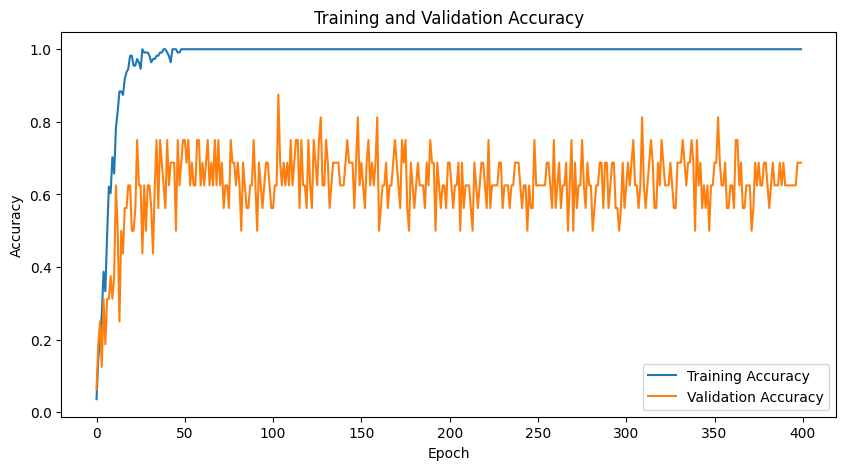

In [7]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Ploting ROC

2/2 [==============================] - 1s 130ms/step


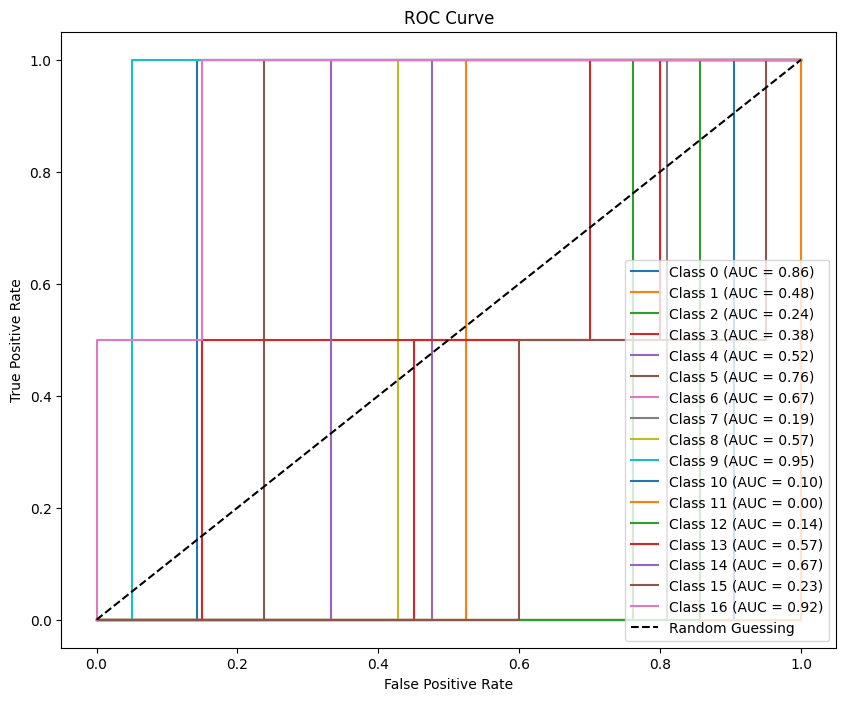

In [8]:
y_pred = model.predict(validation_generator)
y_true = validation_generator.classes
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Ploting Confusion mat

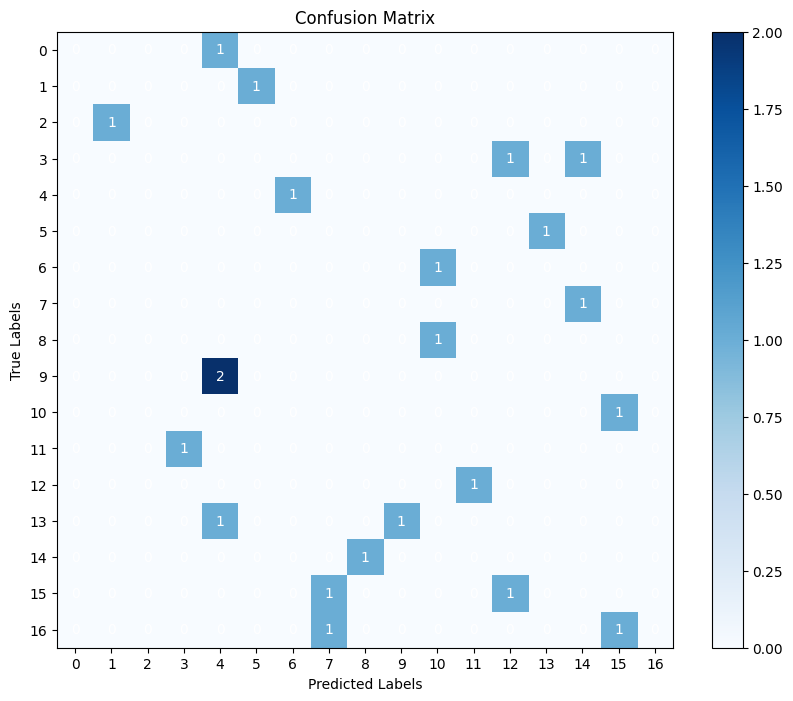

In [9]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(NUM_CLASSES))
plt.yticks(np.arange(NUM_CLASSES))
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()


# f1 score

In [14]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from prettytable import PrettyTable
import pandas as pd

# Assuming you already have the necessary variables defined in your code
train_predictions = model.predict(train_generator)
validation_predictions = model.predict(validation_generator)

# Convert predictions to class labels
train_pred_labels = np.argmax(train_predictions, axis=1)
validation_pred_labels = np.argmax(validation_predictions, axis=1)

# True labels for training and validation sets
train_true_labels = train_generator.classes
validation_true_labels = validation_generator.classes

# Calculate metrics
train_report = classification_report(train_true_labels, train_pred_labels, target_names=train_generator.class_indices)
validation_report = classification_report(validation_true_labels, validation_pred_labels, target_names=validation_generator.class_indices)

# Additional metrics using confusion matrix
train_conf_matrix = confusion_matrix(train_true_labels, train_pred_labels)
validation_conf_matrix = confusion_matrix(validation_true_labels, validation_pred_labels)

# Calculate precision, recall, F1 score, and support
train_precision, train_recall, train_f1_score, train_support = precision_recall_fscore_support(train_true_labels, train_pred_labels)
validation_precision, validation_recall, validation_f1_score, validation_support = precision_recall_fscore_support(validation_true_labels, validation_pred_labels)

# Create PrettyTable for training metrics
train_table = PrettyTable()
train_table.field_names = ["Class", "Precision", "Recall", "F1 Score", "Support"]

# Populate the table with training metrics
for class_name, precision, recall, f1_score, support in zip(
        train_generator.class_indices.keys(),
        train_precision,
        train_recall,
        train_f1_score,
        train_support
):
    train_table.add_row([class_name, precision, recall, f1_score, support])

# Create PrettyTable for validation metrics
validation_table = PrettyTable()
validation_table.field_names = ["Class", "Precision", "Recall", "F1 Score", "Support"]

# Populate the table with validation metrics
for class_name, precision, recall, f1_score, support in zip(
        validation_generator.class_indices.keys(),
        validation_precision,
        validation_recall,
        validation_f1_score,
        validation_support
):
    validation_table.add_row([class_name, precision, recall, f1_score, support])

# Print tables
print("Training Metrics:")
print(train_table)

print("\nValidation Metrics:")
print(validation_table)

# ... (your existing code)

# Create DataFrames for training and validation metrics
train_df = pd.DataFrame({
    'Dataset': 'Training',
    'Class': list(train_generator.class_indices.keys()),
    'Precision': train_precision,
    'Recall': train_recall,
    'F1 Score': train_f1_score,
    'Support': train_support
})

validation_df = pd.DataFrame({
    'Dataset': 'Validation',
    'Class': list(validation_generator.class_indices.keys()),
    'Precision': validation_precision,
    'Recall': validation_recall,
    'F1 Score': validation_f1_score,
    'Support': validation_support
})

# Concatenate DataFrames
combined_df = pd.concat([train_df, validation_df], ignore_index=True)

# Save combined DataFrame to an Excel sheet
combined_excel_path = 'combined_metrics.xlsx'
combined_df.to_excel(combined_excel_path, index=False)

print(f"Combined metrics saved to {combined_excel_path}")


2/2 [==============================] - 0s 177ms/step
Training Metrics:
+-------+-----------+--------+---------------------+---------+
| Class | Precision | Recall |       F1 Score      | Support |
+-------+-----------+--------+---------------------+---------+
|   0   |    0.0    |  0.0   |         0.0         |    7    |
|   1   |   0.0625  | 0.875  | 0.11666666666666667 |    8    |
|   10  |    0.0    |  0.0   |         0.0         |    6    |
|   2   |    0.0    |  0.0   |         0.0         |    9    |
|   3   |    0.0    |  0.0   |         0.0         |    7    |
|   4   |    0.0    |  0.0   |         0.0         |    8    |
|   5   |    0.0    |  0.0   |         0.0         |    6    |
|   6   |    0.0    |  0.0   |         0.0         |    6    |
|   7   |    0.0    |  0.0   |         0.0         |    6    |
|   8   |    0.0    |  0.0   |         0.0         |    8    |
|   9   |    0.0    |  0.0   |         0.0         |    7    |
|  box  |    0.0    |  0.0   |         0.0     

c:\Users\ksaqu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ksaqu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ksaqu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Combined metrics saved to combined_metrics.xlsx
